<a href="https://colab.research.google.com/github/arcweld/DSI_Capstone_2/blob/main/Capstone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: Predictive Maintenance Project
This notebook explores a database created by NASA, the "Turbofan Engine Degradation Simulation Data Set", by appying a variety of machine learning models and developing an understanding of how such models could help in the predictive maintenance decision making process.

## Imports

In [2]:
import os
import zipfile
import urllib

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 12]
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, balanced_accuracy_score
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split as tts
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
import itertools


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Modules and Helper Functions

In [3]:
DOWNLOAD_ROOT = 'https://ti.arc.nasa.gov/'
ENG_PATH = os.path.join('data','nasa_eng')
ENG_URL = DOWNLOAD_ROOT + 'c/6' 

def fetch_eng_data(eng_url=ENG_URL, eng_path=ENG_PATH):
    os.makedirs(eng_path, exist_ok=True)
    if not os.path.exists(os.path.join(eng_path,'CMAPSSData.zip')):
        zip_path = os.path.join(eng_path, 'CMAPSSData.zip')
        urllib.request.urlretrieve(eng_url, zip_path)
        eng_zip = zipfile.ZipFile(zip_path, 'r')
        eng_zip.extractall(path=eng_path)
        eng_zip.close()
        print('All files downloaded and extracted')
    else:
        print('All files in place')
        
    
def load_train_data(series_n=1):
    new_col = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21", 'x1', 'x2']
    df = pd.read_csv(f'data/nasa_eng/train_FD00{series_n}.txt', sep=' ', names=new_col)
    df.drop(['x1', 'x2'], axis=1, inplace=True)
    return df

    
def load_test_data(series_n=1):
    new_col = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21", 'x1', 'x2']
    df = pd.read_csv(f'data/nasa_eng/test_FD00{series_n}.txt', sep=' ', names=new_col, header=None)
    df.drop(['x1', 'x2'], axis=1, inplace=True)
    truth = pd.read_csv(f'data/nasa_eng/RUL_FD00{series_n}.txt', header=None, names=['eol'])
    truth['id'] = truth.index +1
    df = df.merge(truth, on=['id'], how='left')
    return df

def normalize_data(df1, *df2):
    scale = MinMaxScaler()
    scale.fit(df1.loc[:,'s1':'s21'])
    scale.transform(df1.loc[:,'s1':'s21'])
    if df2:
        scale.transform(df2.loc[:,'s1':'s21'])
        return df1, df2
    return df1

def add_labels(df):
    if 'eol' not in df.columns:
        fail = df.groupby('id').cycle.max()
        df['eol'] = df['id'].apply(lambda x: fail[x])

    df['RUL'] = df['eol'] - df['cycle']
    df.drop('eol', axis=1, inplace=True)
    df['f30'] = df['RUL'].apply(lambda x: 2 if x <= 10 else 1 if x <=30 else 0)
    df['f10'] = df['RUL'].apply(lambda x: 1 if x <= 10 else 0)

    return df

def window_avg_sd(df, win=5):
    sensor = {f's{i}': [f'a{i}', f'sd{i}'] for i in range(1,22) }
    if 'a1' in df.columns: 
        print('DF previously transformed')
        return None
    for s, agg in sensor.items():
        for id in df.id.unique():
            avg = df[s].groupby(df['id']).rolling(window=win, min_periods=4).mean()
            sd = df[s].groupby(df['id']).rolling(window=win, min_periods=4).std()
        df.insert(len(df.columns)-4, f'{agg[0]}', avg.values)
        df.insert(len(df.columns)-4, f'{agg[1]}', sd.values)
    
    return df

def window_trending(df, win=10):
    if 'a1' not in df.columns: 
        df = window_avg_sd(df)
    sensor = {f's{i}': [f'a{i}', f'incr{i}', f'dec{i}'] for i in range(1,22) }
    for s, agg in sensor.items():
        for id in df.id.unique():
            incr = df.groupby(df['id']).rolling(win, method='table', min_periods=5).apply(lambda x: x.loc[:,agg[0]].max(), raw=True, engine="numba")
            dec = df.groupby(df['id']).rolling(win, method='table', min_periods=5).apply(lambda x: x.loc[:,agg[0]].min(), raw=True, engine="numba")
        df.insert(len(df.columns)-4, f'{agg[1]}', incr.values)
        df.insert(len(df.columns)-4, f'{agg[2]}', dec.values)
    
    return df

# Tensorflow functions

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
        
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]



In [ ]:
!ls 

data  sample_data


# Load Data

In [4]:
fetch_eng_data()

All files downloaded and extracted


In [5]:
df1 = add_labels(load_train_data(1))
df_holdout = add_labels(load_test_data(1))


# Exploratory Data Analysis and Visualisation

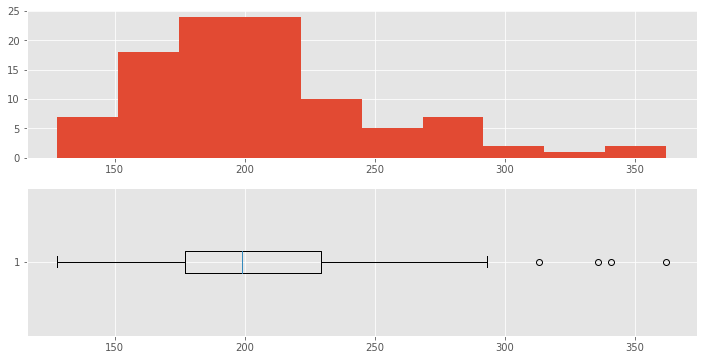

In [ ]:
train1_fail = df1.groupby('id').cycle.max()

fig, axs = plt.subplots(2, figsize=(12,6))
axs[0].hist(train1_fail)
axs[1].boxplot(train1_fail, vert=False);

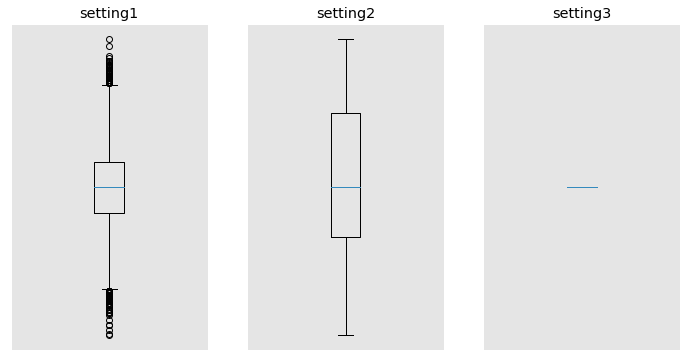

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12,6))
for i in range(3):
    axs[i].boxplot(df1.iloc[:,i+2])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(label=f'setting{i+1}')

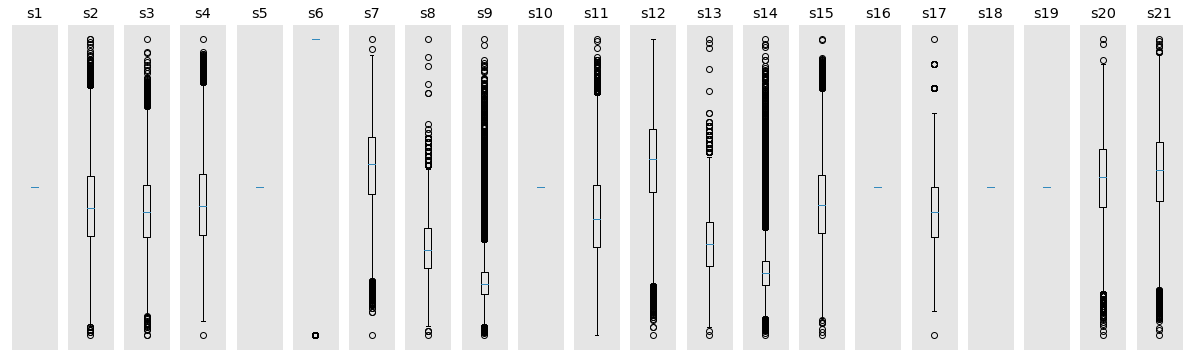

In [ ]:
fig, axs = plt.subplots(1,21, figsize=(21,6))
for i in range(21):
    axs[i].boxplot(df1.iloc[:,i+5])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(label=f'{df1.columns[i+5]}')

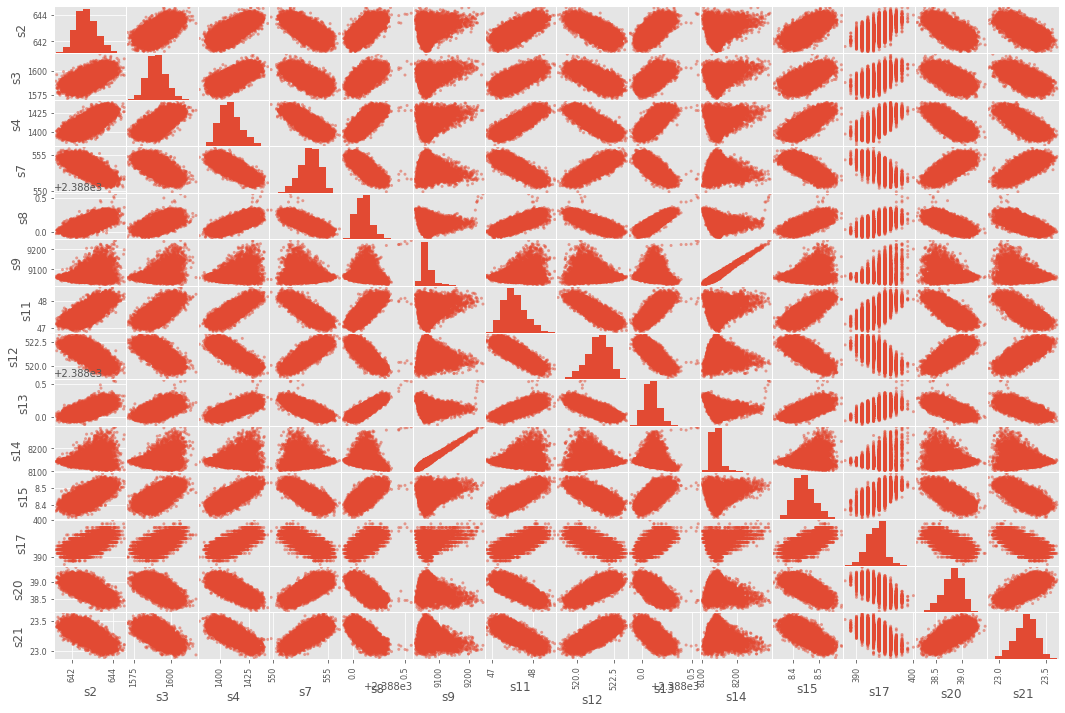

In [ ]:
scatter_matrix(df1.iloc[:,np.r_[6,7,8,11,12,13,15,16,17,18,19,21,24,25]], figsize=(18,12));

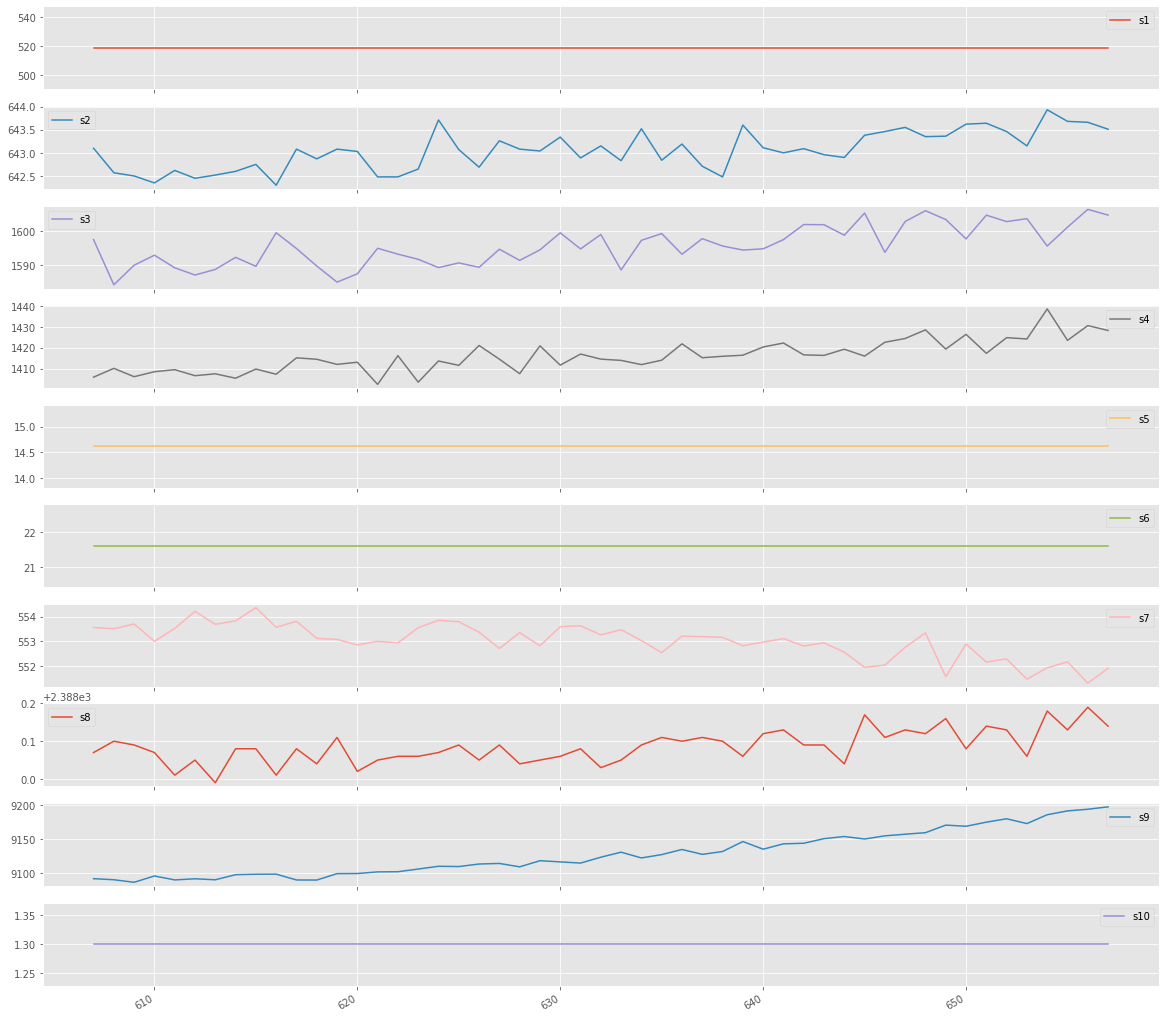

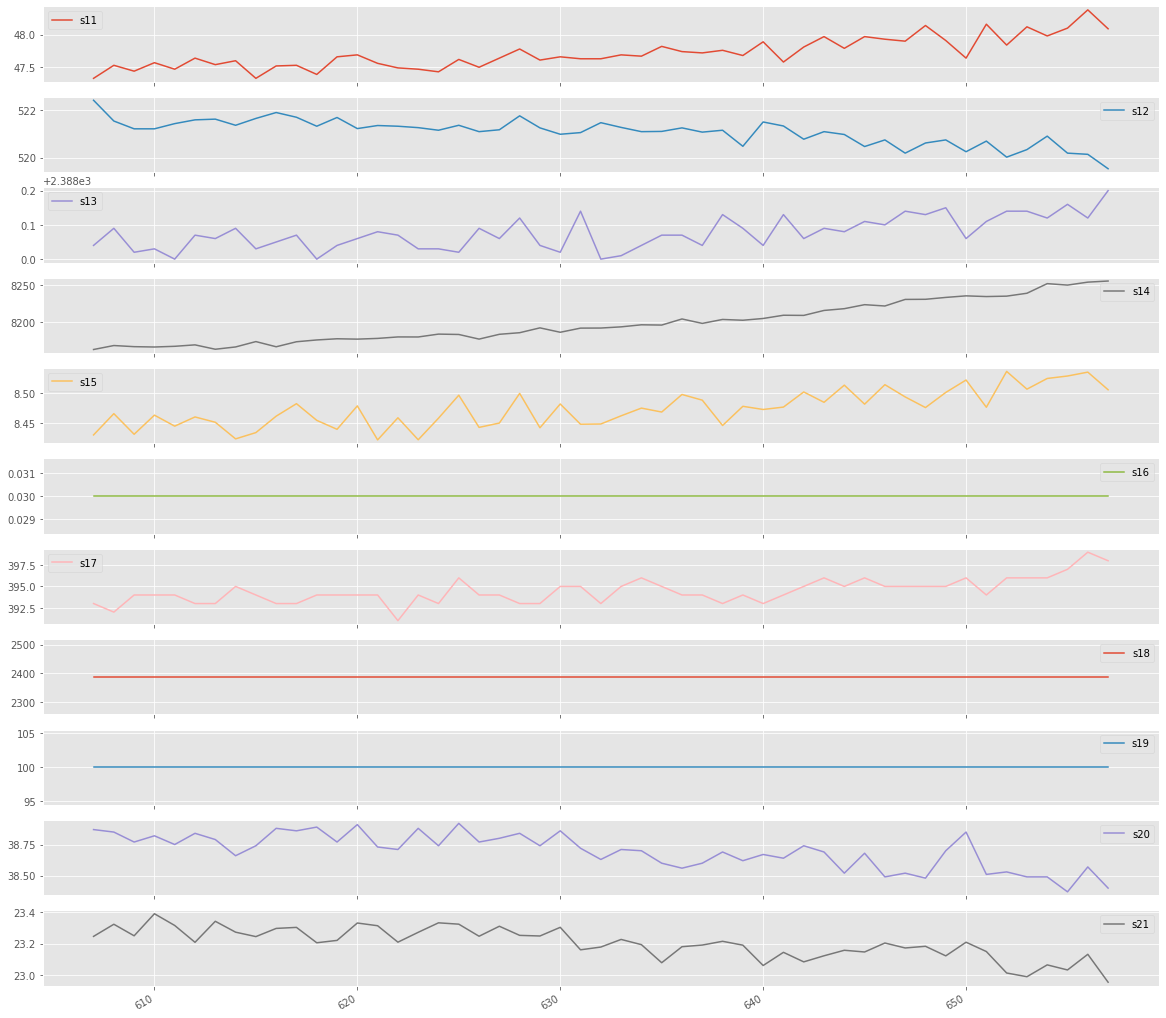

In [ ]:
engine_id3 = df1[df1['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20));

In [ ]:
window_avg_sd(df1)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,a1,sd1,a2,sd2,a3,sd3,a4,sd4,a5,sd5,a6,sd6,a7,sd7,a8,sd8,a9,sd9,a10,sd10,a11,sd11,a12,sd12,a13,sd13,a14,sd14,a15,sd15,a16,sd16,a17,sd17,a18,sd18,a19,sd19,a20,sd20,a21,sd21,s21,RUL,f30,f10
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,518.67,0.0,642.1675,0.250117,1588.075,3.855909,1402.4525,1.559645,14.62,0.0,21.61,0.000000e+00,554.205,0.313103,2388.0725,0.029861,9048.170,3.881555,1.3,0.0,47.340,0.171659,522.305,0.495950,2388.050,0.029439,8134.2925,3.050906,8.409325,0.028117,0.03,0.0,391.5,1.000000,2388.0,0.0,100.0,0.0,38.9725,0.076322,23.390175,0.037977,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,518.67,0.0,642.2080,0.234776,1587.030,4.075678,1403.2060,2.159440,14.62,0.0,21.61,0.000000e+00,554.164,0.286234,2388.0700,0.026458,9049.566,4.587366,1.3,0.0,47.328,0.151063,522.282,0.432574,2388.048,0.025884,8134.1940,2.651326,8.413340,0.025953,0.03,0.0,391.8,1.095445,2388.0,0.0,100.0,0.0,38.9580,0.073621,23.393020,0.033498,23.4044,187,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,518.67,0.0,643.4480,0.230261,1599.270,1.605506,1427.2700,4.656871,14.62,0.0,21.61,6.228568e-08,551.604,0.393230,2388.2220,0.046043,9066.416,3.686839,1.3,0.0,48.156,0.060249,519.890,0.460000,2388.232,0.037014,8141.1300,2.446753,8.520120,0.027684,0.03,0.0,395.8,1.643168,2388.0,0.0,100.0,0.0,38.4080,0.163003,23.079640,0.086540,22.9735,4,2,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,518.67,0.0,643.4500,0.231193,1599.924,2.814397,1430.0900,2.555181,14.62,0.0,21.61,6.228568e-08,551.548,0.485046,2388.2340,0.035777,9067.348,2.008761,1.3,0.0,48.128,0.076616,519.708,0.242322,2388.234,0.035777,8139.7380,2.750731,8.525060,0.022507,0.03,0.0,395.4,1.516575,2388.0,0.0,100.0,0.0,38.3560,0.142583,23.096120,0.093479,23.1594,3,2,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,518.67,0.0,643.5160,0.125817,1600.454,3.028907,1429.9400,2.660160,14.62,0.0,21.61,6.228568e-08,551.328,0.454610,2388.2240,0.019494,9067.014,2.099412,1.3,0.0,48.108,0.069065,519.688,0.201544,2388.244,0.026077,813

In [ ]:
df1.dropna(axis=0, inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20331 entries, 3 to 20630
Data columns (total 71 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20331 non-null  int64  
 1   cycle     20331 non-null  int64  
 2   setting1  20331 non-null  float64
 3   setting2  20331 non-null  float64
 4   setting3  20331 non-null  float64
 5   s1        20331 non-null  float64
 6   s2        20331 non-null  float64
 7   s3        20331 non-null  float64
 8   s4        20331 non-null  float64
 9   s5        20331 non-null  float64
 10  s6        20331 non-null  float64
 11  s7        20331 non-null  float64
 12  s8        20331 non-null  float64
 13  s9        20331 non-null  float64
 14  s10       20331 non-null  float64
 15  s11       20331 non-null  float64
 16  s12       20331 non-null  float64
 17  s13       20331 non-null  float64
 18  s14       20331 non-null  float64
 19  s15       20331 non-null  float64
 20  s16       20331 non-null  fl

In [ ]:
# window_trending(df1)

TypingError: ignored

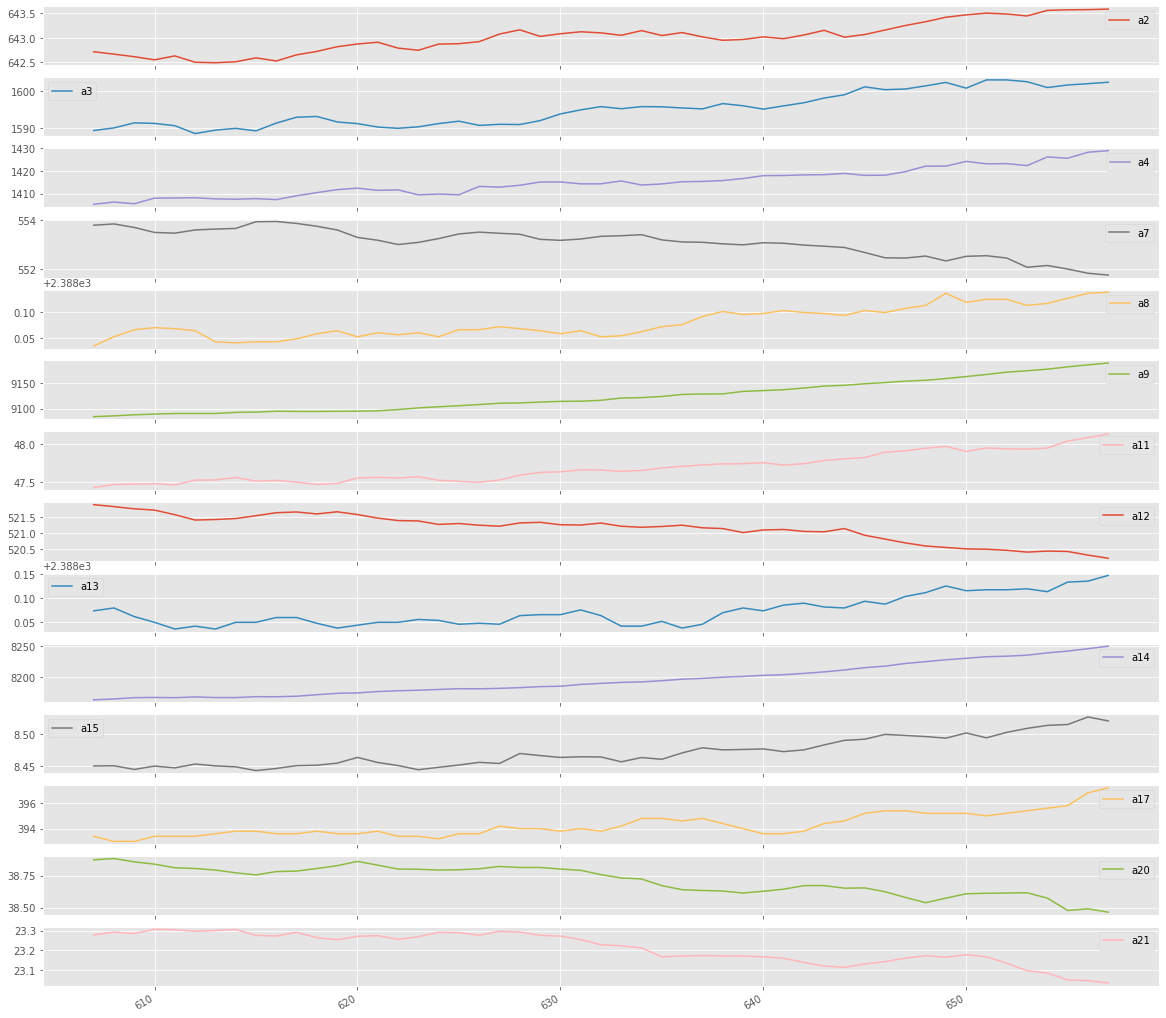

In [ ]:
engine_id3 = df1[df1['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['a2', 'a3', 'a4', 'a7', 'a8', 'a9', 'a11', 'a12', 'a13', 'a14', 'a15', 'a17', 'a20', 'a21']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]

# plotting sensor data for engine ID 3 prior to a failure point
engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20));

In [ ]:
q25 = pd.DataFrame(data=np.arange(51), columns=['RUL'])
q75 = pd.DataFrame(data=np.arange(51), columns=['RUL'])
sensor = [f's{i}' for i in range(1,22) ]
for s in sensor:
        q25.insert(len(q25.columns), f'{s}', df1[df1['RUL']<=50][s].groupby(df1['RUL']).quantile(0.25))
        q75.insert(len(q75.columns), f'{s}', df1[df1['RUL']<=50][s].groupby(df1['RUL']).quantile(0.75))
q25.set_index('RUL')

In [ ]:
eng_id3 = df1[df1['id'] == 3]
eng_id3.set_index('RUL')

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,a1,sd1,a2,sd2,a3,sd3,a4,sd4,a5,sd5,a6,sd6,a7,sd7,a8,sd8,a9,sd9,a10,sd10,a11,sd11,a12,sd12,a13,sd13,a14,sd14,a15,sd15,a16,sd16,a17,sd17,a18,sd18,a19,sd19,a20,sd20,a21,sd21,s21,f30,f10
RUL,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
178,3,1,0.0008,0.0005,100.0,518.67,642.04,1584.20,1398.13,14.62,21.61,553.96,2388.06,9056.95,1.3,47.14,522.24,2388.00,8138.40,8.4207,0.03,391,2388,100.0,38.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.3205,0,0
177,3,2,-0.0010,0.0000,100.0,518.67,642.66,1587.04,1398.62,14.62,21.61,554.76,2388.05,9059.67,1.3,47.35,522.03,2388.01,8137.38,8.3949,0.03,390,2388,100.0,39.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.4369,0,0
176,3,3,0.0013,-0.0002,100.0,518.67,642.07,1580.75,1401.10,14.62,21.61,554.51,2388.03,9050.43,1.3,46.94,522.16,2388.01,8137.20,8.3820,0.03,393,2388,100.0,39.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.3162,0,0
175,3,4,0.0008,-0.0002,100.0,518.67,642.50,1580.12,1395.76,14.62,21.61,554.48,2388.07,9060.43,1.3,47.44,522.31,2388.07,8139.35,8.3940,0.03,391,2388,100.0,38.94,518.67,0.0,642.3175,0.310309,1583.0275,3.220532,1398.4025,2.189435,14.62,0.0,21.61,1.414306e-08,554.4275,0.335994,2388.0525,0.017078,9056.870,4.545826,1.3,0.0,47.2175,0.223663,522.185,0.120139,2388.0225,0.032016,8138.0825,0.996607,8.39790,0.016298,0.03,0.0,391.25,1.258306,2388.0,0.0,100.0,0.0,39.000,0.060553,23.390925,0.086589,23.4901,0,0
174,3,5,0.0020,0.0004,100.0,518.67,641.97,1581.48,1394.05,14.62,21.61,554.14,2388.01,9054.36,1.3,47.16,522.00,2388.03,8135.99,8.4233,0.03,391,2388,100.0,38.90,518.67,0.0,642.2480,0.310435,1582.7180,2.873642,1397.5320,2.717365,14.62,0.0,21.61,1.224825e-08,554.3700,0.318119,2388.0440,0.024083,9056.368,4.093705,1.3,0.0,47.2060,0.195397,522.148,0.132929,2388.0240,0.027928,8137.6640,1.273040,8.40298,0.018118,0.03,0.0,391.20,1.095445,2388.0,0.0,100.0,0.0,38.980,0.068920,23.396540,0.076032,23.4190,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,3,175,-0.0030,0.0004,100.0,518.67,643.15,1603.74,1424.17,14.62,21.61,551.47,2388.06,9172.76,1.3,48.12,520.34,2388.14,8238.86,8.5066,0.03,396,2388,100.0,38.49,518.67,0.0,643.4460,0.201941,1602.5180,2.764836,1422.3920,3.880144,14.62,0.0,21.61,1.404748e-08,552.0760,0.578515,2388.1140,0.042190,9173.354,4.302875,1.3,0.0,47.9340,0.213026,520.412,0.309144,2388.1200,0.036742,8235.3620,2.111047,8.50844,0.022625,0.03,0.0,395.40,0.894427,2388.0,0.0,100.0,0.0,38.616,0.155177,23.097240,0.092158,22.9909,2,1
3,3,176,-0.0008,0.0002,100.0,518.67,643.93,1595.61,1438.51,14.62,21.61,551.93,2388.18,9185.88,1.3,47.98,520.91,2388.12,8251.82,8.5245,0.03,396,2388,100.0,38.49,518.67,0.0,643.5600,0.285044,1600.9440,4.030661,1426.2280,7.698404,14.62,0.0,21.61,1.404748e-08,552.1480,0.519153,2388.1180,0.048166,9176.428,6.626158,1.3,0.0,47.9480,0.213354,520.444,0.357393,2388.1140,0.032863,8239.0780,7.333923,8.51312,0.023142,0.03,0.0,395.60,0.894427,2388.0,0.0,100.0,0.0,38.574,0.155177,23.085860,0.091771,23.0656,2,1
2,3,177,-0.0041,-0.0002,100.0,518.67,643.68,1601.21,1423.50,14.62,21.61,552.17,2388.13,9191.53,1.3,48.10,520.19,2388.16,8249.86,8.5286,0.03,397,2388,100.0,38.37,518.67,0.0,643.5720,0.289430,1601.6400,3.616068,1425.6520,7.791368,14.62,0.0,21.61,1.404748e-08,552.0040,0.325699,2388.1280,0.043243,9180.978,7.773189,1.3,0.0,48.0400,0

In [ ]:
eng_id3_50 = eng_id3[eng_id3['RUL'] <= engine_id3['RUL'].min() + 50]

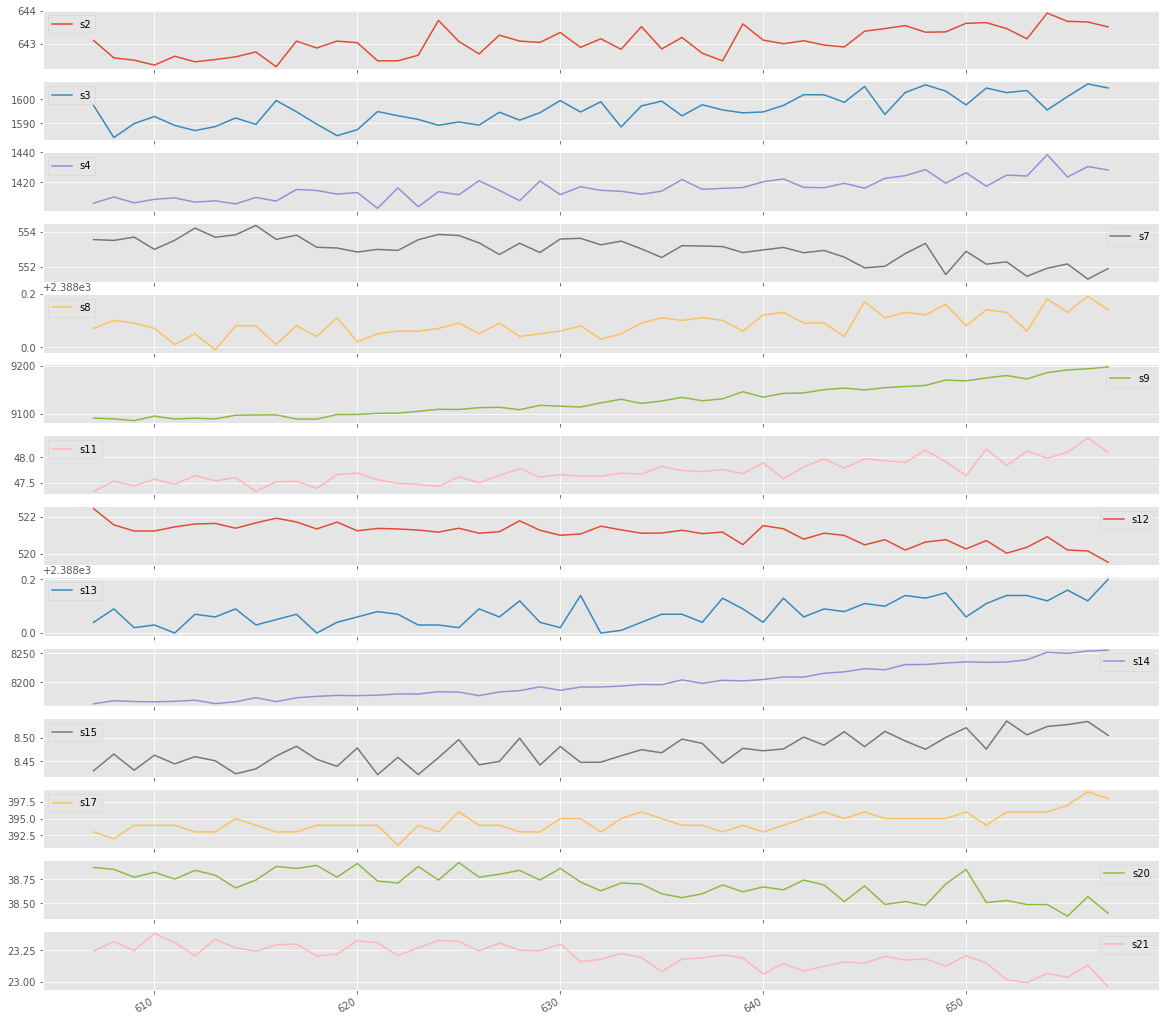

In [ ]:
disp_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']

# plotting sensor data for engine ID 3 prior to a failure point
eng_id3_50[disp_cols].plot(subplots=True, sharex=True, figsize=(20,20));



In [ ]:
index = range(50,-1,-1)
anti_index = range(51)

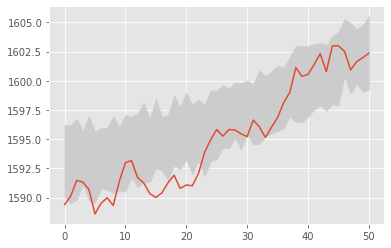

In [ ]:
fig, ax = plt.subplots()
ax.plot(anti_index,eng_id3_50['a3'])
ax.fill_between(index, q25.s3.values.ravel(), q75.s3.values.ravel(), color='0.8')

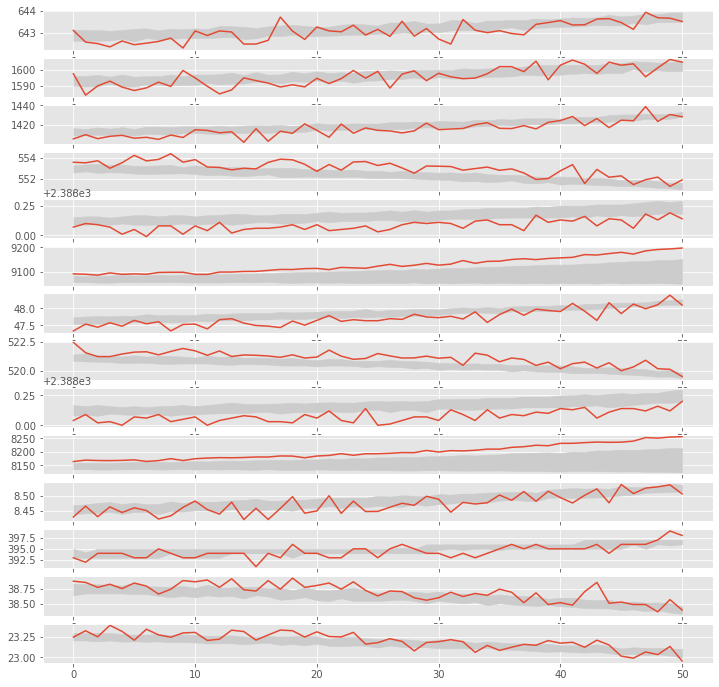

In [ ]:
fig, ax = plt.subplots(len(disp_cols), figsize=(12,12))
for i, disp in enumerate(disp_cols):
  ax[i].fill_between(index, q25[disp].values.ravel(), q75[disp].values.ravel(), color='0.8')
  ax[i].plot(anti_index,eng_id3_50[disp])

# Final cleaning of data

## Train/Test Split

In [ ]:
n_eng = df1['id'].unique()
test_index = np.random.choice(n_eng, int(0.2*len(n_eng)))
df_test = df1[df1['id'].isin(test_index)]

In [7]:
df_train = df1[~df1['id'].isin(test_index)]
# df_train

### Training set

In [12]:
X = df_train.drop(['RUL','f10','f30'], axis=1)
y_reg = df_train['RUL']
y_clf = df_train['f10']
y_mclf = df_train['f30']

### Testing set

In [13]:
X_test = df_test.drop(['RUL','f10','f30'], axis=1)
y_test_reg = df_test['RUL']
y_test_clf = df_test['f10']
y_test_mclf = df_test['f30']

## Additional considered modifications of the data

In [ ]:
window_avg_sd(df1)

if `window_avg_sd` function run, will need to re-run train/test split (above) and dropna (below)

In [ ]:
df_train.dropna()
df_test.dropna()

# Build models

## Linear Regression

In [ ]:
reg = LinearRegression()

reg.fit(X, y_reg)
reg.score(X, y_reg)

0.6905168389121343

In [ ]:
print(f'MSE: {mean_squared_error(y_reg, reg.predict(X))}')

MSE: 1619.2518709716835


In [ ]:
reg.score(X_test, y_test_reg)

0.7297966146915859

## OLS with StatsModel

In [ ]:
model = sm.OLS(y_reg, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     668.4
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:02:34   Log-Likelihood:                -86735.
No. Observations:               16961   AIC:                         1.736e+05
Df Residuals:                   16911   BIC:                         1.740e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
id             0.2888      0.011     27.306      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


## Logistics Regression

In [ ]:
log = LogisticRegression(max_iter=10000000)

log.fit(X, y_clf)
y_pred = log.predict(X)
log.score(X, y_clf)
confusion_matrix(y_pred, y_clf)

array([[15930,   137],
       [  118,   776]])

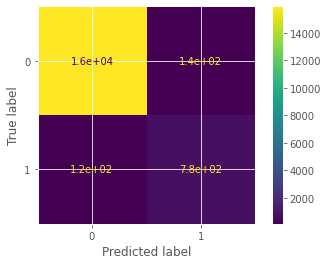

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_clf), display_labels=log.classes_)
disp.plot();

In [ ]:
print(f'F1 score: {f1_score(y_clf, y_pred)}')
print(f'accuracy: {accuracy_score(y_clf, y_pred)}')
print(f'recall: {recall_score(y_clf, y_pred)}')
print(f'precision: {precision_score(y_clf, y_pred)}')

F1 score: 0.8588821250691755
accuracy: 0.9849655091091327
recall: 0.8499452354874042
precision: 0.8680089485458613


In [ ]:
balanced_accuracy_score(y_clf, y_pred)

0.9212961471554668

## Random Forest

In [ ]:
clf = RandomForestClassifier()
clf.fit(X,y_mclf)
clf.score(X,y_mclf)

1.0

In [ ]:
y_pred = clf.predict(X)
cm = confusion_matrix(y_pred, y_mclf)

In [ ]:
clf.score(X_test,y_test_mclf)

0.9477744807121662

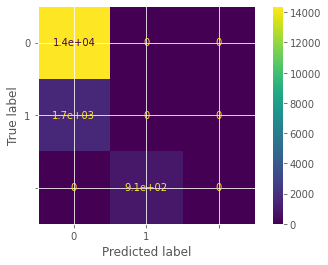

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_clf), display_labels=log.classes_)
disp.plot();

In [ ]:
y_pred = clf.predict(X_test)
y_pred.reshape(1,-1)

array([[0, 0, 0, ..., 2, 2, 2]], dtype=int64)

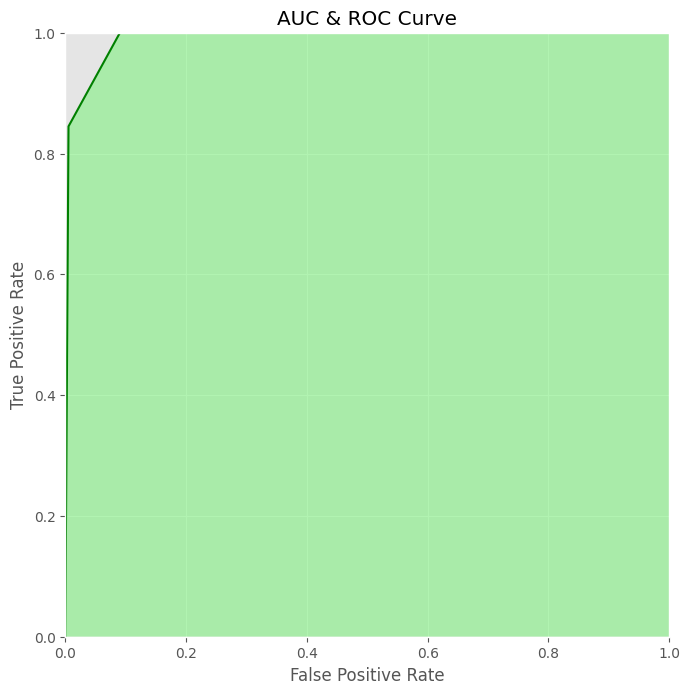

In [ ]:
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test_clf, y_pred)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Gradient Boosting Model



### Binary Classification with lightGBM

In [ ]:
lgb = LGBMClassifier(random_state=0, metric='auc')
lgb.fit(X, y_clf)
lgb.score(X, y_clf)

1.0

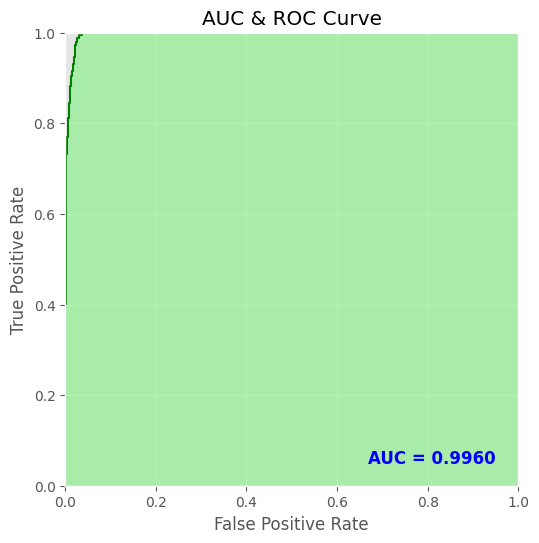

In [ ]:
y_pred = lgb.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test_clf, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test_clf, y_pred)

plt.figure(figsize=(6, 6), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Regressor with sklearn

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X, y_reg)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
gbr.predict(X)
gbr.score(X, y_reg)

0.8935723623215447

In [15]:
gbr.predict(X_test)
gbr.score(X_test, y_test_reg)

0.879691619215863

In [18]:
gbr.feature_importances_

array([1.79412682e-01, 5.14957860e-01, 1.27323811e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.34300984e-03, 1.11174506e-03,
       7.22149951e-02, 0.00000000e+00, 4.93134272e-05, 2.04386362e-02,
       2.04500432e-03, 2.28646165e-02, 0.00000000e+00, 9.22789908e-02,
       3.82483778e-02, 3.17587454e-03, 1.30584507e-02, 1.73595408e-02,
       0.00000000e+00, 1.25666512e-03, 0.00000000e+00, 0.00000000e+00,
       3.51651097e-03, 1.26549944e-02])

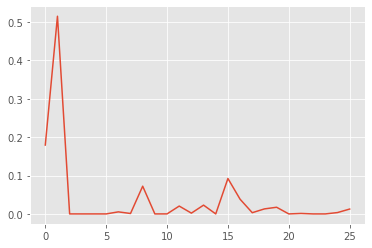

In [20]:
plt.plot(gbr.feature_importances_)

## Neural Networks with TensorFlow (LSTM) as Classifier

In [ ]:
# MODELLING.....pick a large window size of 50 cycles
seq_length = 3

In [ ]:
seq_cols = ["cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]

In [ ]:
# generator for the sequences
seq_gen = (list(gen_sequence(df1[df1['id']==id], seq_length, seq_cols)) 
           for id in df1['id'].unique())

In [ ]:
# # gen_sequence(id_df, seq_length, seq_cols):
# data_array = eng_id3[seq_cols].values
# num_elements = data_array.shape[0]
# for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
#     yield data_array[start:stop, :]

In [ ]:
len(next(seq_gen))

126

In [ ]:
eng_id3.shape

(179, 71)

In [ ]:
eng = gen_sequence(eng_id3, 5, ["s1","s2","s3","s4","s5","s6"])

In [ ]:
next(eng)

array([[ 518.67,  642.04, 1584.2 , 1398.13,   14.62,   21.61],
       [ 518.67,  642.66, 1587.04, 1398.62,   14.62,   21.61],
       [ 518.67,  642.07, 1580.75, 1401.1 ,   14.62,   21.61],
       [ 518.67,  642.5 , 1580.12, 1395.76,   14.62,   21.61],
       [ 518.67,  641.97, 1581.48, 1394.05,   14.62,   21.61]])

In [ ]:
next(eng)

array([[ 518.67,  642.66, 1587.04, 1398.62,   14.62,   21.61],
       [ 518.67,  642.07, 1580.75, 1401.1 ,   14.62,   21.61],
       [ 518.67,  642.5 , 1580.12, 1395.76,   14.62,   21.61],
       [ 518.67,  641.97, 1581.48, 1394.05,   14.62,   21.61],
       [ 518.67,  642.65, 1581.26, 1397.98,   14.62,   21.61]])

In [ ]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(20331, 3, 25)

In [ ]:
df1.id.value_counts().sort_values()

39    125
91    132
57    134
70    134
58    144
     ... 
83    290
67    310
96    333
92    338
69    359
Name: id, Length: 100, dtype: int64

In [ ]:
df1[df1['id']==99]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,a1,sd1,a2,sd2,a3,sd3,a4,sd4,a5,sd5,a6,sd6,a7,sd7,a8,sd8,a9,sd9,a10,sd10,a11,sd11,a12,sd12,a13,sd13,a14,sd14,a15,sd15,a16,sd16,a17,sd17,a18,sd18,a19,sd19,a20,sd20,a21,sd21,s21,RUL,f30,f10
20249,99,4,-0.0021,-0.0003,100.0,518.67,642.49,1587.64,1394.60,14.62,21.61,554.43,2388.06,9060.90,1.3,47.28,521.86,2388.07,8133.19,8.3839,0.03,391,2388,100.0,39.15,518.67,0.0,642.080,0.346218,1587.6525,1.061489,1398.1375,6.313849,14.62,0.0,21.610,7.180083e-08,554.2925,0.153270,2388.0625,0.023629,9058.750,4.865676,1.3,0.0,47.310,0.069761,522.1675,0.511363,2388.0525,0.022174,8132.390,0.833507,8.40755,0.019258,0.03,0.0,391.25,0.500000,2388.0,0.0,100.0,0.0,39.0525,0.068496,23.401125,0.019105,23.3759,181,0,0
20250,99,5,0.0008,0.0002,100.0,518.67,642.25,1583.02,1403.49,14.62,21.61,554.19,2388.02,9052.97,1.3,47.18,521.95,2388.06,8132.30,8.4181,0.03,392,2388,100.0,38.98,518.67,0.0,642.114,0.309322,1586.7260,2.266513,1399.2080,5.968950,14.62,0.0,21.610,6.218134e-08,554.2720,0.140428,2388.0540,0.027928,9057.594,4.943458,1.3,0.0,47.284,0.083845,522.1240,0.453409,2388.0540,0.019494,8132.372,0.722959,8.40966,0.017332,0.03,0.0,391.40,0.547723,2388.0,0.0,100.0,0.0,39.0380,0.067602,23.397380,0.018544,23.3824,180,0,0
20251,99,6,0.0033,-0.0004,100.0,518.67,641.46,1586.64,1401.90,14.62,21.61,554.11,2388.02,9055.16,1.3,47.15,522.38,2388.04,8140.25,8.3751,0.03,390,2388,100.0,38.85,518.67,0.0,642.068,0.393726,1586.8200,2.247354,1401.3600,3.921486,14.62,0.0,21.610,6.218134e-08,554.2760,0.134090,2388.0520,0.030332,9055.762,3.227045,1.3,0.0,47.232,0.064576,522.0700,0.386199,2388.0500,0.020000,8134.176,3.412379,8.40392,0.023436,0.03,0.0,391.20,0.836660,2388.0,0.0,100.0,0.0,39.0060,0.109225,23.401360,0.021357,23.4206,179,0,0
20252,99,7,-0.0032,-0.0001,100.0,518.67,642.02,1584.95,1407.88,14.62,21.60,553.74,2388.02,9054.70,1.3,47.31,522.31,2388.07,8133.85,8.4420,0.03,392,2388,100.0,39.11,518.67,0.0,642.086,0.387853,1586.0940,2.119335,1402.4840,4.921781,14.62,0.0,21.608,4.472136e-03,554.1460,0.255793,2388.0400,0.028284,9056.058,2.995133,1.3,0.0,47.244,0.073689,522.2100,0.293513,2388.0520,0.021679,8134.406,3.325677,8.40626,0.027036,0.03,0.0,391.20,0.836660,2388.0,0.0,100.0,0.0,39.0180,0.118195,23.398800,0.018889,23.4092,178,0,0
20253,99,8,0.0002,-0.0005,100.0,518.67,642.68,1587.40,1391.01,14.62,21.61,554.67,2388.02,9054.30,1.3,47.45,521.96,2388.05,8140.33,8.4213,0.03,393,2388,100.0,39.09,518.67,0.0,642.180,0.473022,1585.9300,1.937627,1399.7760,6.848608,14.62,0.0,21.608,4.472136e-03,554.2280,0.349886,2388.0280,0.017889,9055.606,3.070029,1.3,0.0,47.274,0.118870,522.0920,0.235521,2388.0580,0.013038,8135.984,3.969217,8.40808,0.027830,0.03,0.0,391.60,1.140175,2388.0,0.0,100.0,0.0,39.0360,0.121573,23.385500,0.031704,23.3394,177,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20426,99,181,-0.0015,-0.0001,100.0,518.67,643.72,1600.39,1428.03,14.62,21.61,551.09,2388.27,9054.88,1.3,48.23,519.60,2388.29,8123.55,8.4885,0.03,396,2388,100.0,38.50,518.67,0.0,643.536,0.209714,1602.3380,9.145959,1429.0440,1.283600,14.62,0.0,21.610,6.237127e-08,551.4200,0.368646,2388.2540,0.027019,9056.984,1.938151,1.3,0.0,48.152,0.092574,519.6120,0.270407,2388.2520,0.044944,8129.424,5.432001,8.49526,0.021620,0.03,0.0,396.40,0.547723,2388.0,0.0,100.0,0.0,38.5260,0.070214,23.068840,0.088657,23.0425,4,2,1
20427,99,182,-0.0027,-0.0003,100.0,518.67,643.52,1605.33,1430.32,14.62,21.61,551.61,2388.26,9063.31,1.3,48.16,519.32,2388.27,8130.99,8.5124,0.03,393,2388,100.0,38.39,518.67,0.0,643.502,0.191494,1604.9120,7.294588,1429.1800,1.393826,14.62,0.0,21.610,6.237127e-08,551.3760,0.316986,2388.2560,0.027019,9058.626,3.082763,1.3,0.0,48.176,0.068775,519.4680,0.150732,2388.264

In [ ]:
eng99 = gen_sequence(df1[df1['id']==99], 50, ['cycle',"s1","s2","s3","s4","s5","s6"])
next(eng99)

array([[   4.  ,  518.67,  642.49, 1587.64, 1394.6 ,   14.62,   21.61],
       [   5.  ,  518.67,  642.25, 1583.02, 1403.49,   14.62,   21.61],
       [   6.  ,  518.67,  641.46, 1586.64, 1401.9 ,   14.62,   21.61],
       [   7.  ,  518.67,  642.02, 1584.95, 1407.88,   14.62,   21.6 ],
       [   8.  ,  518.67,  642.68, 1587.4 , 1391.01,   14.62,   21.61],
       [   9.  ,  518.67,  642.18, 1577.83, 1402.74,   14.62,   21.61],
       [  10.  ,  518.67,  641.89, 1584.64, 1394.87,   14.62,   21.61],
       [  11.  ,  518.67,  641.78, 1584.18, 1402.93,   14.62,   21.61],
       [  12.  ,  518.67,  642.19, 1586.32, 1400.37,   14.62,   21.61],
       [  13.  ,  518.67,  642.61, 1582.63, 1401.53,   14.62,   21.61],
       [  14.  ,  518.67,  642.35, 1586.21, 1405.73,   14.62,   21.61],
       [  15.  ,  518.67,  643.11, 1580.86, 1397.06,   14.62,   21.61],
       [  16.  ,  518.67,  641.85, 1581.41, 1408.72,   14.62,   21.61],
       [  17.  ,  518.67,  642.31, 1583.  , 1400.57,   14.62,   

In [ ]:
# generate labels
label_gen = [gen_labels(df1[df1['id']==id], seq_length, ['f10']) 
             for id in df1['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(20331, 1)

In [ ]:
label_array[130:200,:]

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
np.sum(label_array)

1100.0

In [ ]:
seq_array[0].shape

(50, 25)

In [ ]:
seq_length

50

In [ ]:
# Define the LSTM network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm_c = Sequential()

lstm_c.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100,
         return_sequences=False))
# lstm_c.add(Dropout(0.2))

# lstm_c.add(LSTM(
#           units=50,
#           return_sequences=False))
# lstm_c.add(Dropout(0.2))

lstm_c.add(Dense(units=nb_out, activation='sigmoid'))
lstm_c.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision()])

print(lstm_c.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100)               50400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 50,501
Trainable params: 50,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Train the network
lstm_c.fit(seq_array, label_array, epochs=30, batch_size=200, validation_split=0.10, verbose=1,
          callbacks = [callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')])

# training metrics
scores = lstm_c.evaluate(seq_array, label_array, verbose=1, batch_size=200)
scores

Epoch 1/30
92/92 [==============================] - 4s 20ms/step - loss: 0.3648 - accuracy: 0.9453 - precision_4: 0.0000e+00 - val_loss: 0.2315 - val_accuracy: 0.9513 - val_precision_4: 0.0000e+00
Epoch 2/30
92/92 [==============================] - 1s 14ms/step - loss: 0.2245 - accuracy: 0.9453 - precision_4: 0.0000e+00 - val_loss: 0.1999 - val_accuracy: 0.9513 - val_precision_4: 0.0000e+00
Epoch 3/30
92/92 [==============================] - 1s 14ms/step - loss: 0.2135 - accuracy: 0.9453 - precision_4: 0.0000e+00 - val_loss: 0.1959 - val_accuracy: 0.9513 - val_precision_4: 0.0000e+00
Epoch 4/30
92/92 [==============================] - 1s 14ms/step - loss: 0.2123 - accuracy: 0.9453 - precision_4: 0.0000e+00 - val_loss: 0.1952 - val_accuracy: 0.9513 - val_precision_4: 0.0000e+00
Epoch 5/30
92/92 [==============================] - 1s 14ms/step - loss: 0.2122 - accuracy: 0.9453 - precision_4: 0.0000e+00 - val_loss: 0.1950 - val_accuracy: 0.9513 - val_precision_4: 0.0000e+00
Epoch 6/30
92/9

[0.21043112874031067, 0.9458954334259033, 0.0]

In [ ]:
# make predictions and compute confusion matrix
y_pred = lstm_c.predict(seq_array) 

In [ ]:
len(y_pred)

20331

In [ ]:
np.sum(y_pred)

1088.707

In [ ]:

y_true = label_array
y_true.ravel()

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [ ]:
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f'tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}')

ValueError: ignored

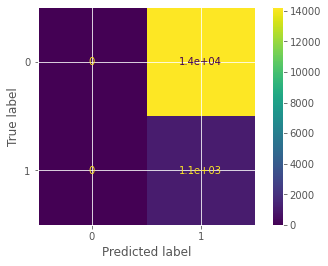

In [ ]:
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot();


In [ ]:
# compute precision and recall
print(f'F1 score: {2 * tp / (2* tp + fp +fn)}')
print(f'accuracy: { (tp + tn) / (tp +fn + fp + tn)}')
print(f'recall: { tp / (tp + fn)}')
print(f'precision: { tp / (tp + fp)}')

F1 score: 0.13389325056296025
accuracy: 0.0717500489204879
recall: 1.0
precision: 0.0717500489204879


In [ ]:

# compute AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_true, y_pred)
print( 'auc = ', auc)

auc =  0.5


## Neural Networks with TensorFlow (LSTM) as Regressor

In [ ]:
# MODELLING.....pick a large window size of 50 cycles
seq_length = 3
seq_cols = ["cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]

# generator for the sequences
seq_gen = (list(gen_sequence(df1[df1['id']==id], seq_length, seq_cols)) 
           for id in df1['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# generate labels
label_gen = [gen_labels(df1[df1['id']==id], seq_length, ['RUL']) 
             for id in df1['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape



(20331, 1)

In [ ]:
# Define the LSTM network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm = Sequential()

lstm.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100,
         return_sequences=False))
# lstm.add(Dropout(0.2))

# lstm.add(LSTM(
#           units=50,
#           return_sequences=False))
# lstm.add(Dropout(0.2))

lstm.add(Dense(units=1, activation='linear'))
lstm.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True), metrics=['mse'])

print(lstm.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               50400     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 50,501
Trainable params: 50,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Train the network
lstm.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.10, verbose=1,
          callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=0, verbose=1, mode='auto')])
          # , callbacks.ReduceLROnPlateau()

# training metrics
scores = lstm.evaluate(seq_array, label_array, verbose=1, batch_size=200)
scores

Epoch 1/100
92/92 [==============================] - 3s 18ms/step - loss: 7388.6982 - mse: 7388.6982 - val_loss: 6608.0137 - val_mse: 6608.0137
Epoch 2/100
92/92 [==============================] - 1s 13ms/step - loss: 4459.7876 - mse: 4459.7876 - val_loss: 6365.9028 - val_mse: 6365.9023
Epoch 3/100
92/92 [==============================] - 1s 13ms/step - loss: 4455.1890 - mse: 4455.1895 - val_loss: 6379.4194 - val_mse: 6379.4204
Epoch 4/100
92/92 [==============================] - 1s 13ms/step - loss: 4455.5786 - mse: 4455.5781 - val_loss: 6355.3135 - val_mse: 6355.3130
Epoch 5/100
92/92 [==============================] - 1s 13ms/step - loss: 4455.3062 - mse: 4455.3062 - val_loss: 6360.7578 - val_mse: 6360.7578
Epoch 6/100
92/92 [==============================] - 1s 13ms/step - loss: 4455.3921 - mse: 4455.3926 - val_loss: 6357.6050 - val_mse: 6357.6055
Epoch 7/100
92/92 [==============================] - 1s 13ms/step - loss: 4455.4243 - mse: 4455.4238 - val_loss: 6358.4805 - val_mse: 63

In [ ]:
# make predictions 
y_pred = lstm.predict(seq_array) 
y_pred.shape

(20331, 1)

In [ ]:
y_pred

array([[104.7196],
       [104.7196],
       [104.7196],
       ...,
       [104.7196],
       [104.7196],
       [104.7196]], dtype=float32)

## 